In [1]:
# Importing our Utilities functions:
from utils import CautDataloaderRegular
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


# Modelling
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import LSTM

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint



# 64, 32
# 32, 16
def LSTM_grid_search_Audio(csv_path,
                           data_dir,
                           feature_type=None,
                           lstm_feat_size_lst=[16, 32, 64, 128, 256],
                           inner_dense_layer_size_lst=[16, 32, 64, 128, 256],
                           epoch_num=100,
                           batch_size=32,
                           verbose=False):
    for lstm_feat_size_tmp in lstm_feat_size_lst:
        for inner_dense_size_tmp in inner_dense_layer_size_lst:
            print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
            print(f"LSTM Layer Size       : {lstm_feat_size_tmp}")
            print(f"Inner Dense Layer Size: {inner_dense_size_tmp}")
            print(f"Epoch Num             : {epoch_num}")
            LSTM_Model_Audio(csv_path=csv_path,
                             data_dir=data_dir,
                             lstm_features_size=lstm_feat_size_tmp,
                             inner_dense_size=inner_dense_size_tmp,
                             epochs_num=epoch_num,
                             feature_type=feature_type,
                             batch_size=batch_size,
                             threshold=0.5,
                             train_verbose=False)
            print("\n\n")
            print("##########################################")
            
        
# # Do grid search:
# LSTM_grid_search_Audio(lstm_feat_size_lst=[16, 32, 64, 128, 256],
#                        inner_dense_layer_size_lst=[16, 32, 64, 128, 256],
#                        epoch_num=100,
#                        batch_size=32,
#                        verbose=False)



def LSTM_Model_Audio(csv_path,
                     data_dir,
                     lstm_features_size,
                     inner_dense_size,
                     epochs_num,
                     feature_type="MFCC",
                     batch_size=32,
                     threshold=0.5,
                     train_verbose=True):

    X_y_data = CautDataloaderRegular.get_X_y_TrainTest_Audio(csv_path=csv_path,
                                                             data_dir=data_dir,
                                                             feature_type=feature_type,
                                                             input_length_in_seconds=3,
                                                             class_to_num_dict={"truth": 0, "lie": 1},
                                                             verbose=train_verbose)
    
    X_train, y_train = X_y_data[0], X_y_data[1]
    X_test, y_test = X_y_data[2], X_y_data[3]
    
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    # setup model's input length, feature amount, and expected class num
    n_timesteps = X_train.shape[1]
    n_features = X_train.shape[2]
    n_outputs = 1
    
    # lstm_features_size, inner_dense_size => default 100
    
    # Setup model:
    model = Sequential()
    model.add(LSTM(lstm_features_size, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(inner_dense_size, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # fit network
    epochs = epochs_num
    batch_size = 32
    train_verbose = train_verbose
    # also, add Early stopping:
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                               patience=15)
    
    model.fit(X_train,
              y_train,
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stopping_callback],
              verbose=train_verbose)
    
    # evaluate model
    _, accuracy = model.evaluate(X_test,
                                 y_test,
                                 batch_size=batch_size,
                                 verbose=0)
    
    # predict on test data:
    y_pred = model.predict(X_test, batch_size=32) 
    y_pred = np.where(y_pred > threshold, 1, 0)
    
    # get metrics (accuracy, precision, recall)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    # log accuracy:
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall", recall)
    
    # show confusion matrix
    CautDataloaderRegular.plot_confusion_matrix(y_test, y_pred)

# MediaPipe (Sequential only, since LSTM can only do sequences):

data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
Processed 100 / 520
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 0
Processed 200 / 520
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 0
Processed 300 / 520
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 1
Processed 400 / 520
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 0
Processed 500 / 520
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 1
Processed 100 / 223
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 1
Processed 200 / 223
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 1
----------------------------
Gathered data shapes:
X_train.shape: (520, 130, 20)
y_train.shape: (520,)
X_test.shape: (223, 130, 20)
y_test.shape: (223,)
(520, 130, 20) (520,) (223, 130, 20) (223,)
Epoch 1/100
17/17 [=============

17/17 [==============================] - 1s 51ms/step - loss: 0.1528 - accuracy: 0.9269
Epoch 73/100
17/17 [==============================] - 1s 55ms/step - loss: 0.1246 - accuracy: 0.9423
Epoch 74/100
17/17 [==============================] - 1s 53ms/step - loss: 0.1237 - accuracy: 0.9442
Epoch 75/100
17/17 [==============================] - 1s 54ms/step - loss: 0.1257 - accuracy: 0.9481
Epoch 76/100
17/17 [==============================] - 1s 52ms/step - loss: 0.1283 - accuracy: 0.9404
Epoch 77/100
17/17 [==============================] - 1s 53ms/step - loss: 0.1452 - accuracy: 0.9269
Epoch 78/100
17/17 [==============================] - 1s 51ms/step - loss: 0.1244 - accuracy: 0.9462
Epoch 79/100
17/17 [==============================] - 1s 51ms/step - loss: 0.1334 - accuracy: 0.9404
Epoch 80/100
17/17 [==============================] - 1s 52ms/step - loss: 0.1341 - accuracy: 0.9462
Epoch 81/100
17/17 [==============================] - 1s 51ms/step - loss: 0.0984 - accuracy: 0.9538
Epo

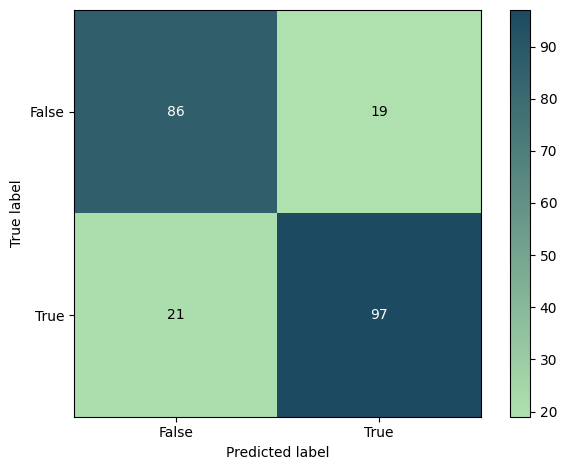

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 97
     - False Positive           : 19
     - True Negative            : 86
     - False Negative           : 21
     - True Positive Rate       :  0.8220338983050848
     - True Negative Rate       :  0.819047619047619
     - Positive Predictive Value:  0.8362068965517241
     - Negative predictive value:  0.8037383177570093
     - False Positive Rate      :  0.18095238095238095
     - False Negative Rate      :  0.17796610169491525
     - False Discovery Rate     :  0.16379310344827586


In [2]:
LSTM_Model_Audio(csv_path="../../../data/data_split_paths_CSVs/",
                 data_dir="../../../data/audio_features/",
                 lstm_features_size=100,
                 inner_dense_size=32,
                 epochs_num=100,
                 batch_size=32,
                 feature_type="MFCC",
                 threshold=0.5,
                 train_verbose=True)

# Let's search for good OpenFace parameter:

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 16
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

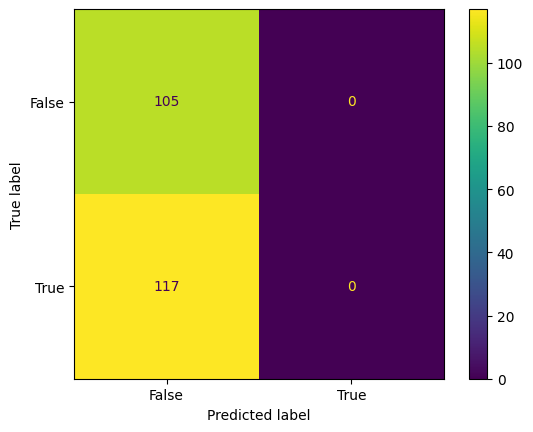




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 32
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

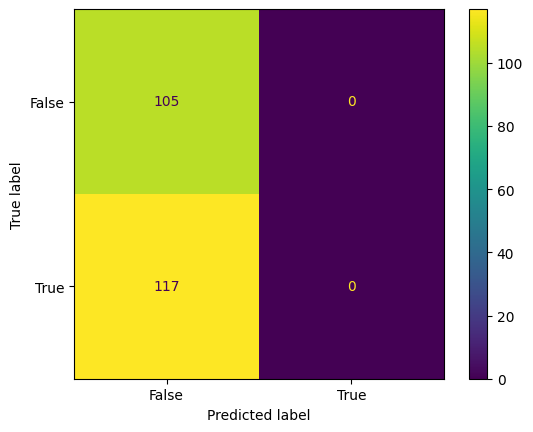




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 64
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

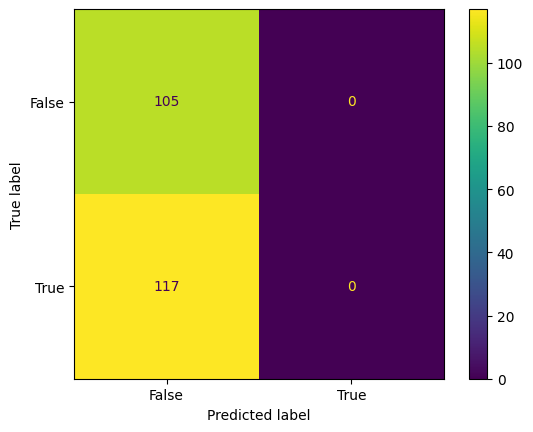




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 128
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

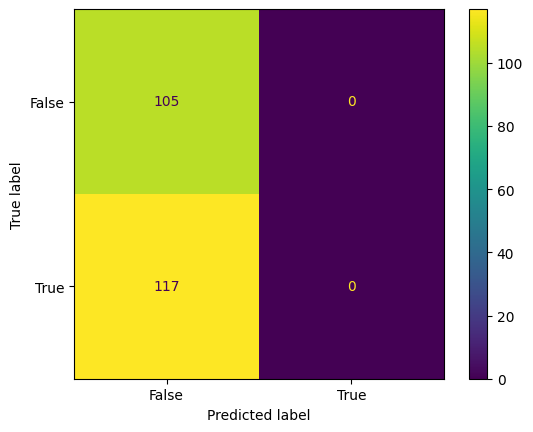




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 256
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

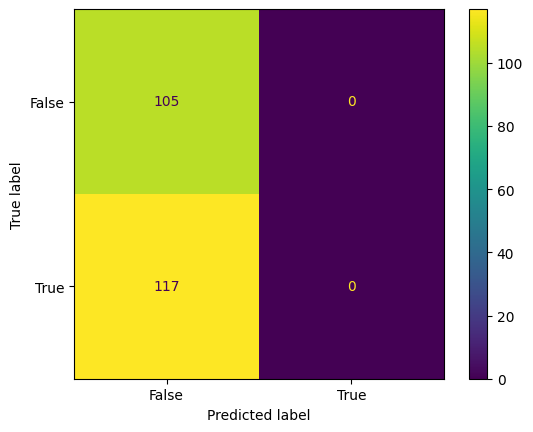




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 16
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 7ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

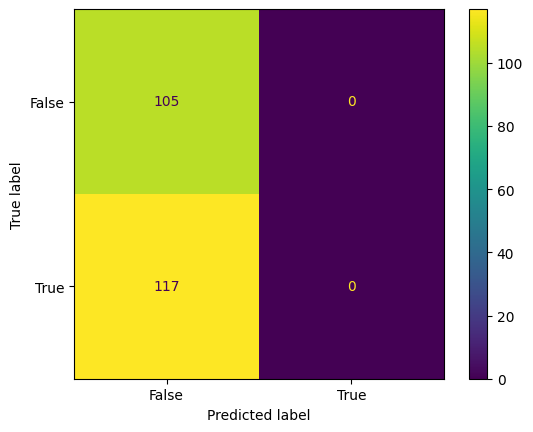




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 32
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 6ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

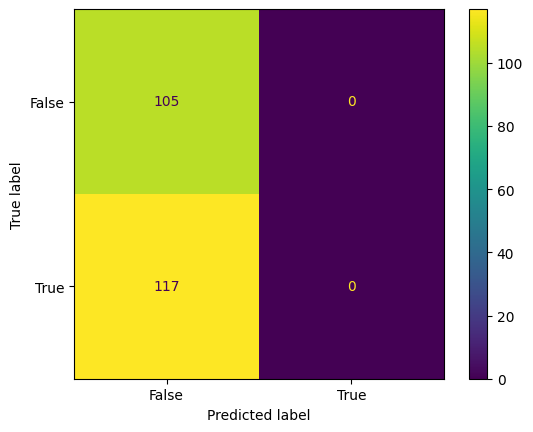




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 64
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 7ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

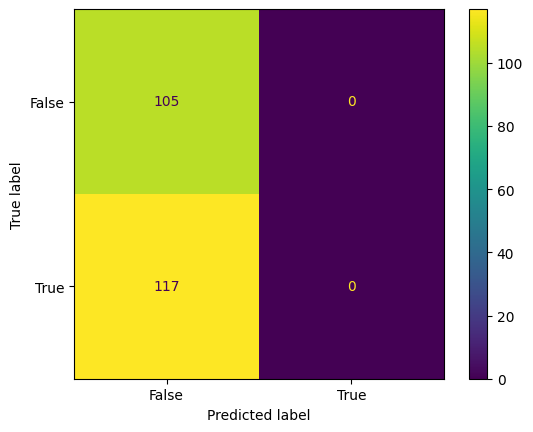




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 128
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 6ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

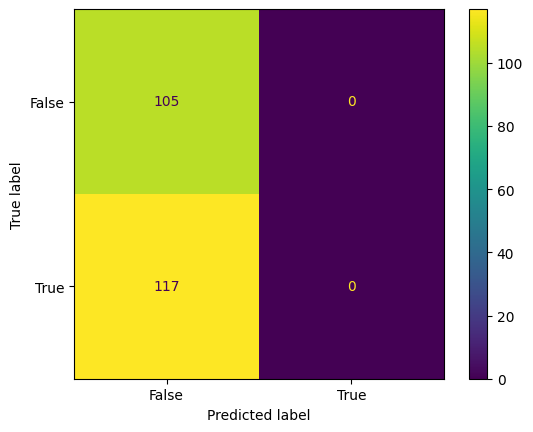




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 256
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 6ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

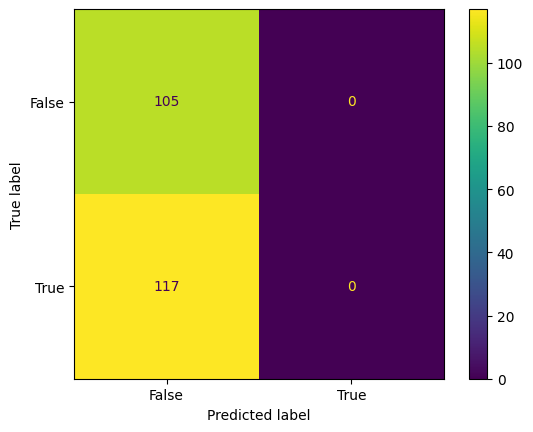




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 16
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 11ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

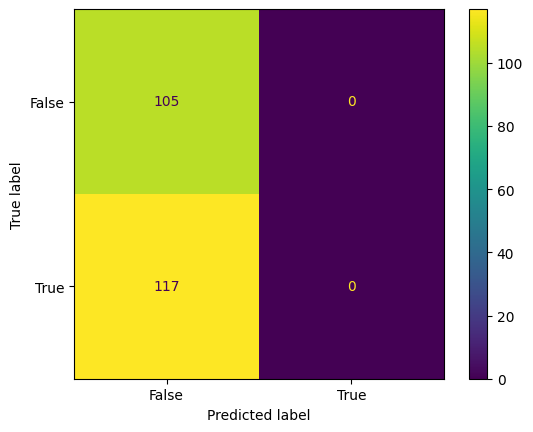




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 32
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 11ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

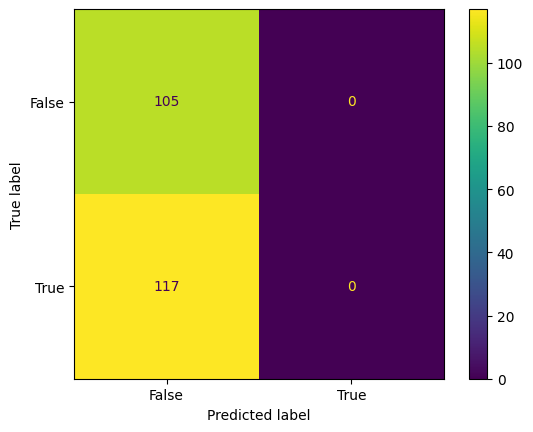




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 64
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 11ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

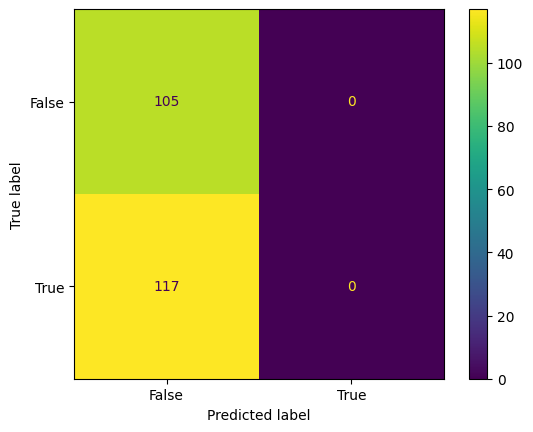




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 128
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 10ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

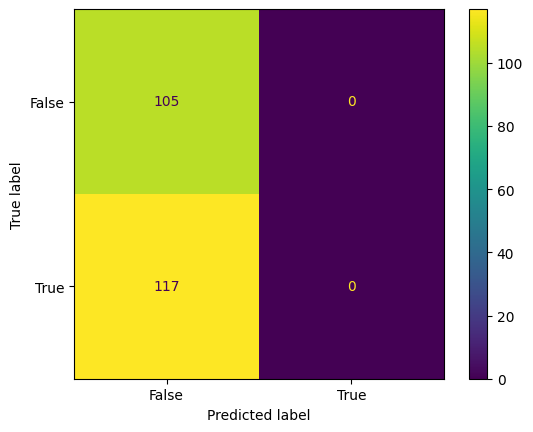




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 256
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 10ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

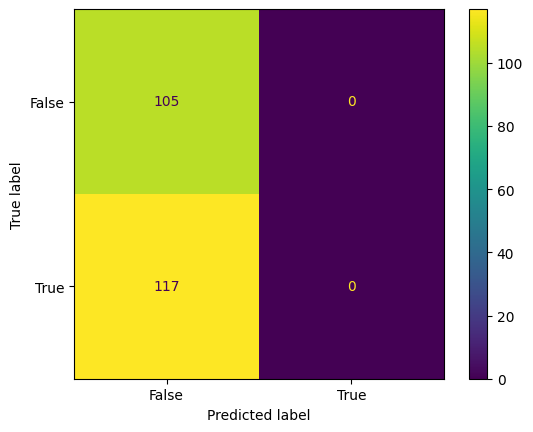




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 16
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 20ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

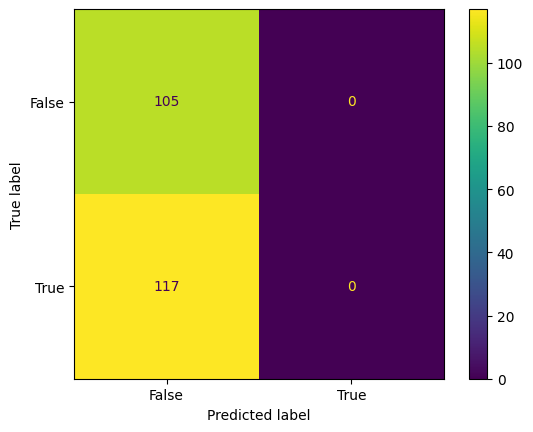




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 32
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 19ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

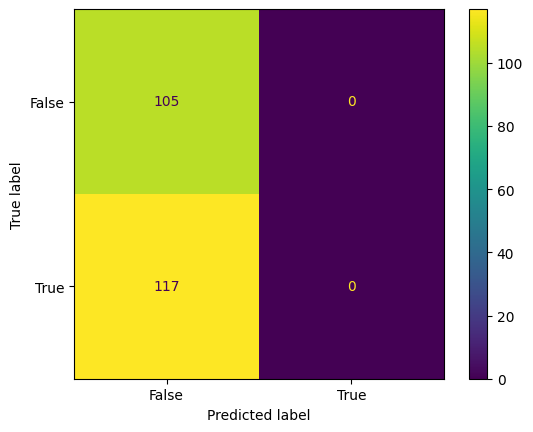




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 64
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 18ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

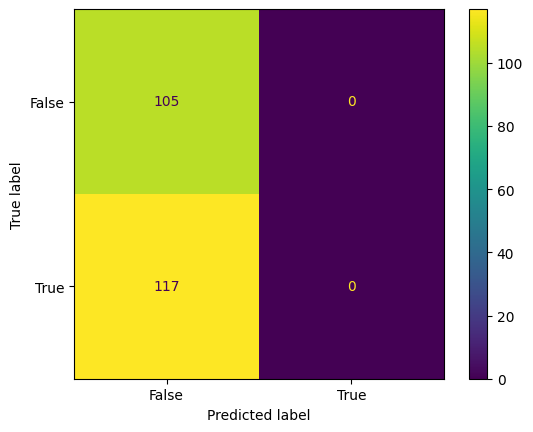




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 128
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 21ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

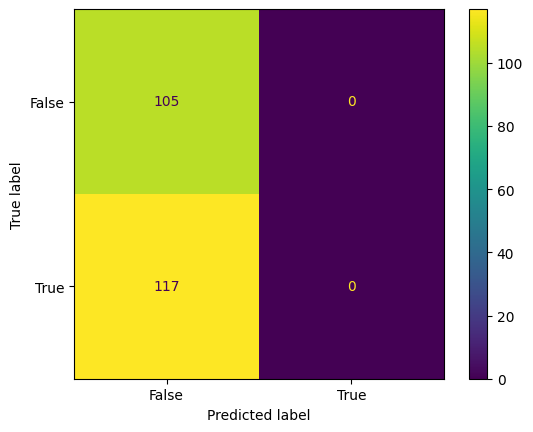




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 256
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 0s 19ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

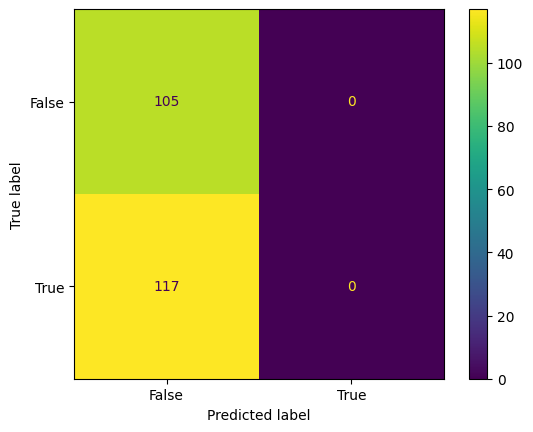




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 16
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 1s 48ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

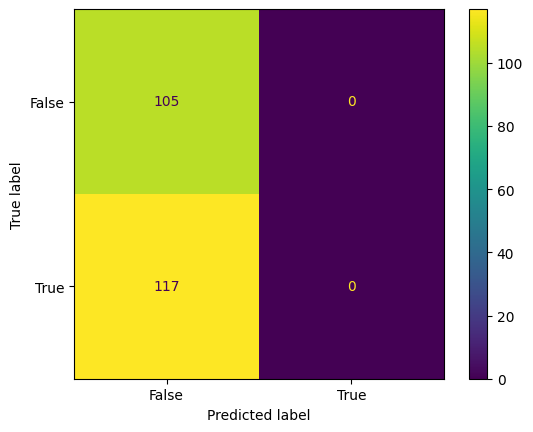




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 32
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 1s 56ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

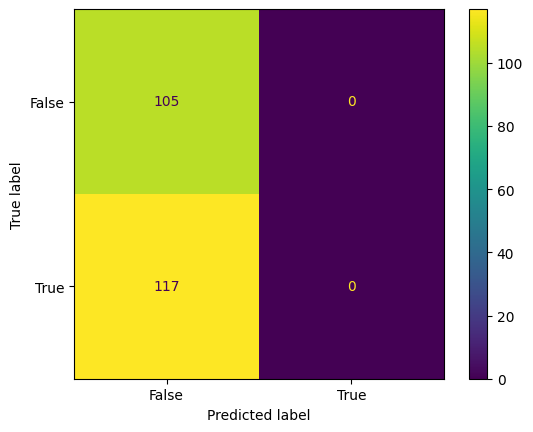




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 64
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 1s 47ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

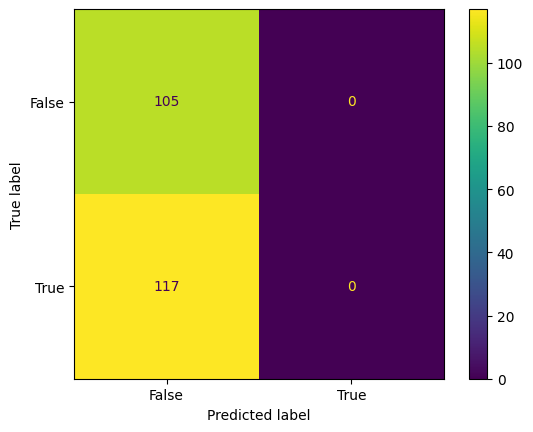




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 128
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 1s 57ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

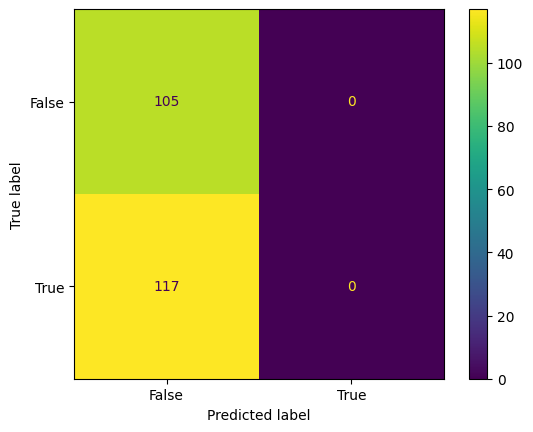




##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 256
Epoch Num             : 100

Selected csv_path: ../../../data/data_split_paths_CSVs/
Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Casting collected data to .npy array type...
Data is collected. Returning X and y data.
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


(520, 90, 27) (520,) (222, 90, 27) (222,)
7/7 [==============================] - 1s 49ms/step
Accuracy: 0.47297297297297297
Precision 0.0
Recall 0.0


C:\Users\lrspr\anaconda3\envs\caut_training\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

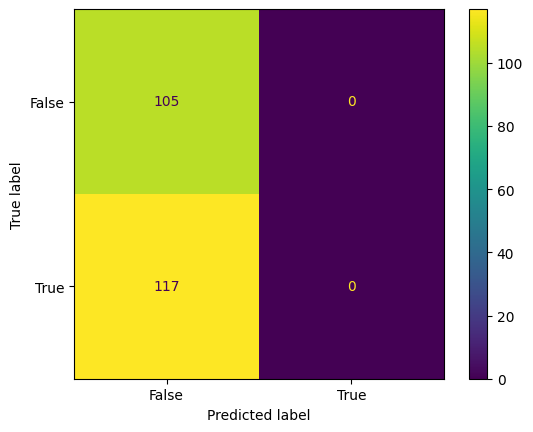




##########################################


In [2]:
LSTM_grid_search(data_mode="OpenFace",
                 csv_path="../../../data/data_split_paths_CSVs/",
                 data_dir="../../../data/visual_features/OpenFace/PyFeatOutput/OpenFace",
                 lstm_feat_size_lst=[10, 30, 64, 100, 120, 150],
                 inner_dense_layer_size_lst=[16, 32, 64, 128],
                 epoch_num=100,
                 approach_type="sequential",
                 batch_size=32)